
In this Notebook we will fine-tune [distilbert-base-uncased](https://huggingface.co/distilbert/distilbert-base-uncased) model and [SMS spam collection](https://huggingface.co/datasets/sms_spam) dataset for our expriment.

## Import Module<a id='section4.1'>

In [1]:
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer
import warnings
import torch
import torch.nn as nn
import time,copy
warnings.filterwarnings("ignore")

## load Data<a id='section4.21'>
load `SMS spam collection` or [Crowdflower corporate messaging](https://huggingface.co/datasets/tasksource/crowdflower/viewer/corporate-messaging) dataset.

In [2]:
from datasets import Dataset,load_dataset
# data_ag_news = load_dataset('ag_news')
dataset_name = 'Crowdflower corporate messaging'
if dataset_name == 'sms_spam':
    data_smsspam = load_dataset('sms_spam')
    num_classes = data_smsspam['train'].features['label'].num_classes
    data_smsspam = data_smsspam.rename_columns({'sms':'text','label':'labels'})
    data = data_smsspam['train'].train_test_split(0.2)
else:
    data_cm = load_dataset('tasksource/crowdflower','corporate-messaging')
    num_classes = data_cm['train'].features['label'].num_classes
    data_cm['train'] = data_cm['train'].remove_columns(['idx'])
    data_cm = data_cm.rename_columns({'label':'labels'})
    data = data_cm['train'].train_test_split(0.2)
data

Generating train split:   0%|          | 0/3118 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2494
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 624
    })
})

## Prepare Data<a id='section4.2'>
Prepare Data For training. 

In [3]:
import re
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader,dataloader
def prepare_data(model_name,data,batch_size):
    # load pretrained tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    def preprocess_data(batch):
        # remove some special characters
        texts = [re.sub("[^ A-Za-z0-9.:;%@&#/\'\",><\-]","",t) for t in batch['text']] 
        return tokenizer(texts)
    train_data = data['train'].map(preprocess_data,batched=True,remove_columns=['text'])
    test_data = data['test'].map(preprocess_data,batched=True,remove_columns=['text'])
    
    data_collector = DataCollatorWithPadding(tokenizer)
    # 
    train_data_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,collate_fn=data_collector)
    test_data_loader = DataLoader(test_data,batch_size=batch_size,collate_fn = data_collector)
    
    return train_data_loader,test_data_loader

2024-05-11 13:58:25.501360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 13:58:25.501476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 13:58:25.625367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Adapter Layer<a id='section4.3'>

In [4]:
#  The adapter is always applied directly to the output of the sub-layer,
#  after the projection back to the input size, but before adding the skip connection back.
def adapter_layer(in_dim:int,adapter_dim:int,out_dim:int)->nn.Sequential:
    adapter = nn.Sequential(*[
        nn.Linear(in_dim,adapter_dim),# Feedforward down-project
        nn.ReLU(), # Non-linear activation function
        nn.Linear(adapter_dim,out_dim)# Feedforward up-project
    ])
    return adapter

## Model<a id='section4.4'>

In [5]:
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
def calculate_total_num_parameter(model):
    # calculate total number of modle parameter and total number of trainable parameter
    total_num_param = 0
    total_num_trainable_param = 0

    for param in model.parameters():
        if param.requires_grad:
            total_num_trainable_param += param.numel()
        total_num_param += param.numel()
    return total_num_param,total_num_trainable_param

class TextClassificationModel(nn.Module):
    def __init__(self,pre_trained_model_path,is_finetune_whole_model:bool,finetune_layer:list,adapter_size:int,num_labels:int) -> None:
        super().__init__()
        # load pretrained model 
        self.model = AutoModelForSequenceClassification.from_pretrained(pre_trained_model_path,num_labels=num_labels)
        if is_finetune_whole_model==False:
            for param in self.model.parameters():
                param.requires_grad = False
            for param in self.model.pre_classifier.parameters():
                param.requires_grad = True
            for param in self.model.classifier.parameters():
                param.requires_grad = True
            assert len(finetune_layer)!=0
            for layer in finetune_layer:
                sub_layer_1_out_feature_dim = self.model.distilbert.transformer.layer[layer].attention.out_lin.out_features
                adapter_layer_1 = adapter_layer(sub_layer_1_out_feature_dim,
                                                adapter_size,
                                                sub_layer_1_out_feature_dim)
                
                self.model.distilbert.transformer.layer[layer].attention.out_lin = nn.Sequential(*[
                    self.model.distilbert.transformer.layer[layer].attention.out_lin,
                    *adapter_layer_1
                ])
                
                
                sub_layer_2_out_feature_dim = self.model.distilbert.transformer.layer[layer].ffn.lin2.out_features
                adapter_layer_2 = adapter_layer(sub_layer_2_out_feature_dim,
                                                adapter_size,
                                                sub_layer_2_out_feature_dim)
                
                self.model.distilbert.transformer.layer[layer].ffn.lin2 = nn.Sequential(*[
                    self.model.distilbert.transformer.layer[layer].ffn.lin2,
                    *adapter_layer_2
                ])
                
    def forward(self,x:torch.Tensor):
        y = self.model(**x)
        return y

## Metrics<a id='section4.5'>

In [6]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
# calculate accuracy score, f1 score, precision socre and recall score
def metrics_calculation(actual_label,predicted_label):
    accuracy = accuracy_score(actual_label,predicted_label)
    f1_sc = f1_score(actual_label,predicted_label,average='micro')            
    precision_sc = precision_score(actual_label,predicted_label,average='micro')            
    recall_sc = recall_score(actual_label,predicted_label,average='micro')       
    return accuracy,f1_sc,precision_sc,recall_sc

## Evaluate Model<a id='section4.6'>

In [7]:
# evaluate torch model 
def eval_model(val_dataloader,model):
    val_loss = 0
    f1_sc = 0
    precision_sc = 0
    recall_sc = 0
    accuracy = 0
    val_data_loader_len = len(val_dataloader)
    with torch.no_grad():
        for val_batch in val_dataloader:
            out = model(val_batch)
            val_loss += out.loss.item()
            predicted_label = out.logits.argmax(axis=-1).detach().cpu().numpy()
            actual_label = val_batch['labels'].cpu().numpy()
            
            val_ac,val_f1,val_precesion,val_recall = metrics_calculation(actual_label,predicted_label)
            
            accuracy += val_ac
            f1_sc += val_f1
            precision_sc += val_precesion
            recall_sc += val_recall
            
    return val_loss/val_data_loader_len,\
            accuracy/val_data_loader_len,\
            f1_sc/val_data_loader_len,\
            precision_sc/val_data_loader_len,\
            recall_sc/val_data_loader_len

## training Model<a id='section4.7'>

In [8]:
from torch.optim import AdamW
from accelerate import Accelerator
from tqdm.auto import tqdm
from transformers import get_scheduler
from collections import defaultdict
accelerator = Accelerator()

def train(pre_trained_model_path :str= 'distilbert/distilbert-base-uncased',
          is_finetune_whole_model:bool=True,
          finetune_layer:list=None,
          adapter_size:int=None,
          num_labels:int=None,
          epoch:int=5,
          train_dataloader:dataloader.DataLoader=None,
          val_dataloader:dataloader.DataLoader=None):
    
    metrices = defaultdict(list)
    
    model = TextClassificationModel(pre_trained_model_path,
                                    is_finetune_whole_model=is_finetune_whole_model,
                                    finetune_layer=finetune_layer,
                                    adapter_size=adapter_size,
                                    num_labels=num_labels)
    
    total_num_param,total_num_trainable_param = calculate_total_num_parameter(model)
    print(f"total number of parameter = {total_num_param/1e06}M")
    print(f"total number of trainable parameter = {total_num_trainable_param/1e06}M")
    
    optimizer = AdamW(model.parameters(),lr=1e-04)
    model,optimizer,train_dataloader,val_dataloader = accelerator.prepare(model,optimizer,train_dataloader,val_dataloader)
    total_steps = len(train_dataloader)*epoch # total training step
    print(total_steps)
    lr_schedular = get_scheduler('linear',
                             optimizer = optimizer,
                             num_warmup_steps = 0,
                             num_training_steps = total_steps)
    progres_bar = tqdm(range(total_steps))
    print("| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |")
    
    for ep in range(1,epoch+1):
        model.train()
        train_loss = 0
        train_accuracy = 0
        # training
        for batch in train_dataloader:
            out = model(batch)
            loss = out.loss
            train_loss += loss.item()
            accelerator.backward(loss)
            optimizer.step()
            lr_schedular.step()
            optimizer.zero_grad()
            
            predicted_label = out.logits.argmax(axis=-1).detach().cpu().numpy()
            actual_label = batch['labels'].cpu().numpy()
            train_acc,_,_,_ = metrics_calculation(actual_label,predicted_label)
            train_accuracy += train_acc
            progres_bar.update(1)
            
            
        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        # validation accuracy
        model.eval()
        val_loss,val_acc,val_f1_score,precision_sc,recall_sc = eval_model(val_dataloader,model)
        metrices['epoch'].append(ep)
        metrices['Train Loss'].append(train_loss)
        metrices['Train Accuracy'].append(train_accuracy)
        metrices['Validation Loss'].append(val_loss)
        metrices['Validation Accuracy'].append(val_acc)
        metrices['Validation F1 Score'].append(val_f1_score)
        metrices['Validation precision Score'].append(precision_sc)
        metrices['Validation Recall Score'].append(recall_sc)
        metrices['trainable parameter'].append(total_num_trainable_param/1e06)
        metrices['total number of parameter'].append(total_num_param)

#         print("|epoch|training loss|")
        if ep%2==0:
            print("| %-5d | %-13f | %-8f | %-12f | %-12f | %-12f | %-10f |" % (ep,train_loss,val_loss,val_acc,val_f1_score,precision_sc,recall_sc))
        
    return model,metrices

In [9]:
batch_size = 64
pre_trained_model_path = 'distilbert/distilbert-base-uncased'
train_dataloader,val_dataloader = prepare_data(pre_trained_model_path,data,batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

In [10]:
# train data loader length
len(train_dataloader)

39

## Expriments<a id='section5'>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('Solarize_Light2')
def summarize_metrices(df,fields,lable='exp_name',x_axis = 'epoch'):
    for f_name in fields:
        plt.figure(figsize=(10,3))
        sns.lineplot(x=df[x_axis],y=df[f_name],hue=df[lable])
        plt.show()

## Expriment 1 - Fine Tune full Model<a id='section5.1'>

In [12]:
all_metric_df = pd.DataFrame()
start_time = time.time()
model,metrices_dict = train(pre_trained_model_path = pre_trained_model_path,
          is_finetune_whole_model=True,
          finetune_layer=list(range(0,6)),
          adapter_size=64,
          num_labels=num_classes,
          epoch=10,
          train_dataloader=train_dataloader,
          val_dataloader = val_dataloader)
time_taken_fwm = time.time() - start_time
temp = pd.DataFrame(metrices_dict)
temp['expriment name'] = 'Fine Tune full Model'
temp['time taken'] = time_taken_fwm
all_metric_df = pd.concat([all_metric_df,temp],ignore_index=True)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


total number of parameter = 66.956548M
total number of trainable parameter = 66.956548M
390


  0%|          | 0/390 [00:00<?, ?it/s]

| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |
| 2     | 0.222748      | 0.252926 | 0.929167     | 0.929167     | 0.929167     | 0.929167   |
| 4     | 0.097840      | 0.291122 | 0.925521     | 0.925521     | 0.925521     | 0.925521   |
| 6     | 0.062975      | 0.268602 | 0.918750     | 0.918750     | 0.918750     | 0.918750   |
| 8     | 0.037379      | 0.301373 | 0.920312     | 0.920312     | 0.920312     | 0.920312   |
| 10    | 0.027999      | 0.300393 | 0.920312     | 0.920312     | 0.920312     | 0.920312   |


## Expriment 2 - Insert Adapter layer in all transformer block and finetune only adapter layer<a id='section5.2'>

In [13]:
start_time = time.time()
model,metrices_adapter = train(pre_trained_model_path = pre_trained_model_path,
          is_finetune_whole_model=False,
          finetune_layer=list(range(0,6)),
          adapter_size=64,
          num_labels=num_classes,
          epoch=10,
          train_dataloader=train_dataloader,
          val_dataloader = val_dataloader)
time_taken_adapter_all = time.time() - start_time
temp = pd.DataFrame(metrices_adapter)
temp['expriment name'] = 'Fine Tune Adapter Layer'
temp['time taken'] = time_taken_adapter_all
all_metric_df = pd.concat([all_metric_df,temp],ignore_index=True)
print(f"time taken - {int(time_taken_adapter_all//60)}M {int(time_taken_adapter_all%60)}S")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


total number of parameter = 68.14618M
total number of trainable parameter = 1.7833M
390


  0%|          | 0/390 [00:00<?, ?it/s]

| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |
| 2     | 0.827197      | 0.787520 | 0.682292     | 0.682292     | 0.682292     | 0.682292   |
| 4     | 0.489174      | 0.399305 | 0.855729     | 0.855729     | 0.855729     | 0.855729   |
| 6     | 0.282425      | 0.317737 | 0.884896     | 0.884896     | 0.884896     | 0.884896   |
| 8     | 0.234199      | 0.305665 | 0.889062     | 0.889062     | 0.889062     | 0.889062   |
| 10    | 0.207847      | 0.303304 | 0.892188     | 0.892188     | 0.892188     | 0.892188   |
time taken - 0M 54S


## Expriment 3 - Insert Adapter layer in top `n` layer and finetune only adapter layer<a id='section5.3'>

In [14]:
mat_top_n = {}
for top_n in range(1,4):
    start_time = time.time()
    print(f"Insert Adapter layer in top {top_n} layer and finetune only adapter layer")
    model,metrices_adapter_top3 = train(pre_trained_model_path = pre_trained_model_path,
              is_finetune_whole_model=False,
              finetune_layer=list(range(6-top_n,6)),
              adapter_size=64,
              num_labels=num_classes,
              epoch=10,
              train_dataloader=train_dataloader,
              val_dataloader = val_dataloader)
    time_taken_adapter_topn = time.time() - start_time
    mat_top_n[top_n] = copy.deepcopy(metrices_adapter_top3)
    temp = pd.DataFrame(metrices_adapter_top3)
    temp['expriment name'] = f'Insert Adapter layer in top-{top_n} layer'
    temp['time taken'] = time_taken_adapter_topn
    all_metric_df = pd.concat([all_metric_df,temp])
    
    print(f"Total time taken - {int(time_taken_adapter_topn//60)}M {int(time_taken_adapter_topn%60)}S")    
    print("===========================================================")

Insert Adapter layer in top 1 layer and finetune only adapter layer


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


total number of parameter = 67.15482M
total number of trainable parameter = 0.79194M
390


  0%|          | 0/390 [00:00<?, ?it/s]

| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |
| 2     | 0.748765      | 0.648878 | 0.738021     | 0.738021     | 0.738021     | 0.738021   |
| 4     | 0.531276      | 0.487922 | 0.812500     | 0.812500     | 0.812500     | 0.812500   |
| 6     | 0.440465      | 0.416060 | 0.843229     | 0.843229     | 0.843229     | 0.843229   |
| 8     | 0.400613      | 0.394400 | 0.857812     | 0.857812     | 0.857812     | 0.857812   |


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


| 10    | 0.388967      | 0.388350 | 0.859375     | 0.859375     | 0.859375     | 0.859375   |
Total time taken - 0M 33S
Insert Adapter layer in top 2 layer and finetune only adapter layer
total number of parameter = 67.353092M
total number of trainable parameter = 0.990212M
390


  0%|          | 0/390 [00:00<?, ?it/s]

| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |
| 2     | 0.778294      | 0.711579 | 0.682292     | 0.682292     | 0.682292     | 0.682292   |
| 4     | 0.479645      | 0.427268 | 0.833854     | 0.833854     | 0.833854     | 0.833854   |
| 6     | 0.331981      | 0.343787 | 0.881771     | 0.881771     | 0.881771     | 0.881771   |
| 8     | 0.285905      | 0.319457 | 0.882292     | 0.882292     | 0.882292     | 0.882292   |
| 10    | 0.275049      | 0.313631 | 0.883854     | 0.883854     | 0.883854     | 0.883854   |
Total time taken - 0M 37S
Insert Adapter layer in top 3 layer and finetune only adapter layer


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


total number of parameter = 67.551364M
total number of trainable parameter = 1.188484M
390


  0%|          | 0/390 [00:00<?, ?it/s]

| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |
| 2     | 0.790036      | 0.708899 | 0.682292     | 0.682292     | 0.682292     | 0.682292   |
| 4     | 0.488785      | 0.444993 | 0.834896     | 0.834896     | 0.834896     | 0.834896   |
| 6     | 0.298182      | 0.325116 | 0.884896     | 0.884896     | 0.884896     | 0.884896   |
| 8     | 0.264463      | 0.324753 | 0.882292     | 0.882292     | 0.882292     | 0.882292   |
| 10    | 0.250141      | 0.311702 | 0.886979     | 0.886979     | 0.886979     | 0.886979   |
Total time taken - 0M 41S


## Expriment 4 - For different size of Adapter layer<a id='section5.4'>

In [15]:
mat_top_n = {}
for adapter_size in [2,8,16,32,64]:
    start_time = time.time()
    print(f"Insert Adapter layer in all transformer block with adapter size {adapter_size}")
    model,metrices_adapter_size = train(pre_trained_model_path = pre_trained_model_path,
              is_finetune_whole_model=False,
              finetune_layer=list(range(0,6)),
              adapter_size=adapter_size,
              num_labels=num_classes,
              epoch=10,
              train_dataloader=train_dataloader,
              val_dataloader = val_dataloader)
    time_taken_adapter = time.time() - start_time
    mat_top_n[top_n] = copy.deepcopy(metrices_adapter_size)
    temp = pd.DataFrame(metrices_adapter_size)
    temp['expriment name'] = f'Adapter size {adapter_size}'
    temp['time taken'] = time_taken_adapter
    all_metric_df = pd.concat([all_metric_df,temp])    
    print(f"Total time taken - {int(time_taken_adapter//60)}M {int(time_taken_adapter%60)}S")    
    print("===========================================================")

Insert Adapter layer in all transformer block with adapter size 2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


total number of parameter = 67.002652M
total number of trainable parameter = 0.639772M
390


  0%|          | 0/390 [00:00<?, ?it/s]

| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |
| 2     | 0.847047      | 0.854366 | 0.682292     | 0.682292     | 0.682292     | 0.682292   |
| 4     | 0.847511      | 0.847215 | 0.682292     | 0.682292     | 0.682292     | 0.682292   |
| 6     | 0.716832      | 0.677573 | 0.713021     | 0.713021     | 0.713021     | 0.713021   |
| 8     | 0.662804      | 0.650903 | 0.718229     | 0.718229     | 0.718229     | 0.718229   |


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


| 10    | 0.641365      | 0.643497 | 0.720833     | 0.720833     | 0.720833     | 0.720833   |
Total time taken - 0M 53S
Insert Adapter layer in all transformer block with adapter size 8
total number of parameter = 67.113316M
total number of trainable parameter = 0.750436M
390


  0%|          | 0/390 [00:00<?, ?it/s]

| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |
| 2     | 0.850188      | 0.849402 | 0.682292     | 0.682292     | 0.682292     | 0.682292   |
| 4     | 0.830223      | 0.824386 | 0.682292     | 0.682292     | 0.682292     | 0.682292   |
| 6     | 0.654837      | 0.630399 | 0.740104     | 0.740104     | 0.740104     | 0.740104   |
| 8     | 0.570675      | 0.596152 | 0.764062     | 0.764062     | 0.764062     | 0.764062   |


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


| 10    | 0.547022      | 0.585533 | 0.770312     | 0.770312     | 0.770312     | 0.770312   |
Total time taken - 0M 52S
Insert Adapter layer in all transformer block with adapter size 16
total number of parameter = 67.260868M
total number of trainable parameter = 0.897988M
390


  0%|          | 0/390 [00:00<?, ?it/s]

| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |
| 2     | 0.842547      | 0.840875 | 0.682292     | 0.682292     | 0.682292     | 0.682292   |
| 4     | 0.764218      | 0.695559 | 0.693750     | 0.693750     | 0.693750     | 0.693750   |
| 6     | 0.553099      | 0.527528 | 0.775521     | 0.775521     | 0.775521     | 0.775521   |
| 8     | 0.442146      | 0.439632 | 0.829167     | 0.829167     | 0.829167     | 0.829167   |


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


| 10    | 0.411263      | 0.427574 | 0.838542     | 0.838542     | 0.838542     | 0.838542   |
Total time taken - 0M 53S
Insert Adapter layer in all transformer block with adapter size 32
total number of parameter = 67.555972M
total number of trainable parameter = 1.193092M
390


  0%|          | 0/390 [00:00<?, ?it/s]

| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |
| 2     | 0.842191      | 0.834011 | 0.682292     | 0.682292     | 0.682292     | 0.682292   |
| 4     | 0.622832      | 0.587278 | 0.743750     | 0.743750     | 0.743750     | 0.743750   |
| 6     | 0.431708      | 0.410806 | 0.842708     | 0.842708     | 0.842708     | 0.842708   |
| 8     | 0.324365      | 0.367436 | 0.866146     | 0.866146     | 0.866146     | 0.866146   |


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


| 10    | 0.292802      | 0.359928 | 0.870833     | 0.870833     | 0.870833     | 0.870833   |
Total time taken - 0M 53S
Insert Adapter layer in all transformer block with adapter size 64
total number of parameter = 68.14618M
total number of trainable parameter = 1.7833M
390


  0%|          | 0/390 [00:00<?, ?it/s]

| epoch | training loss | val loss | val accuracy | val_f1_score | val_pression | val_recall |
| 2     | 0.830725      | 0.805210 | 0.682292     | 0.682292     | 0.682292     | 0.682292   |
| 4     | 0.512915      | 0.467172 | 0.820312     | 0.820312     | 0.820312     | 0.820312   |
| 6     | 0.304078      | 0.345594 | 0.888542     | 0.888542     | 0.888542     | 0.888542   |
| 8     | 0.243485      | 0.327847 | 0.886979     | 0.886979     | 0.886979     | 0.886979   |
| 10    | 0.223526      | 0.324805 | 0.885938     | 0.885938     | 0.885938     | 0.885938   |
Total time taken - 0M 53S


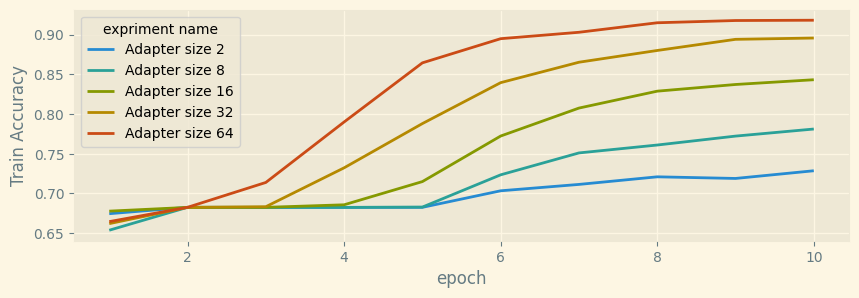

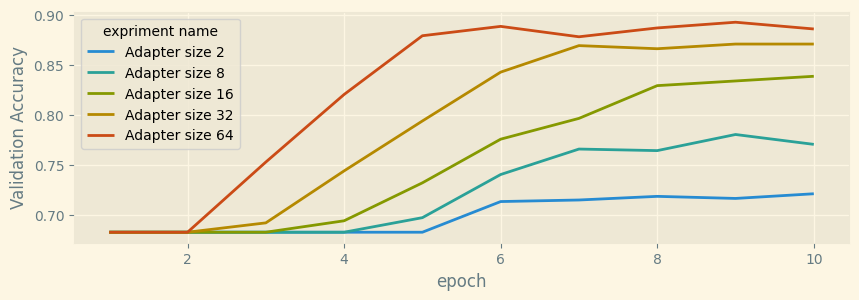

In [16]:
exp_4_mat = all_metric_df.loc[all_metric_df['expriment name'].str.startswith('Adapter')]
summarize_metrices(exp_4_mat,['Train Accuracy','Validation Accuracy'],lable='expriment name',x_axis = 'epoch')

# Summarize All Expriments<a id='section6'>
Now let's gather all expriments results and plot.

In [17]:
def summarize_all_expriment_box_plot(df,x,y,xlabel,ylabel,title,postfix_add,hue=None,figsize=(10,5),is_show_label=True):
    sns.set(style="dark")
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=figsize)
    sns.barplot(x=x, y=y,hue=hue,data=df,)
    if is_show_label:
        for bar, val in zip(plt.gca().patches, df[y]):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{val}{postfix_add}", ha='center', va='bottom')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=75)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    

## Time Taken In Each Experiments

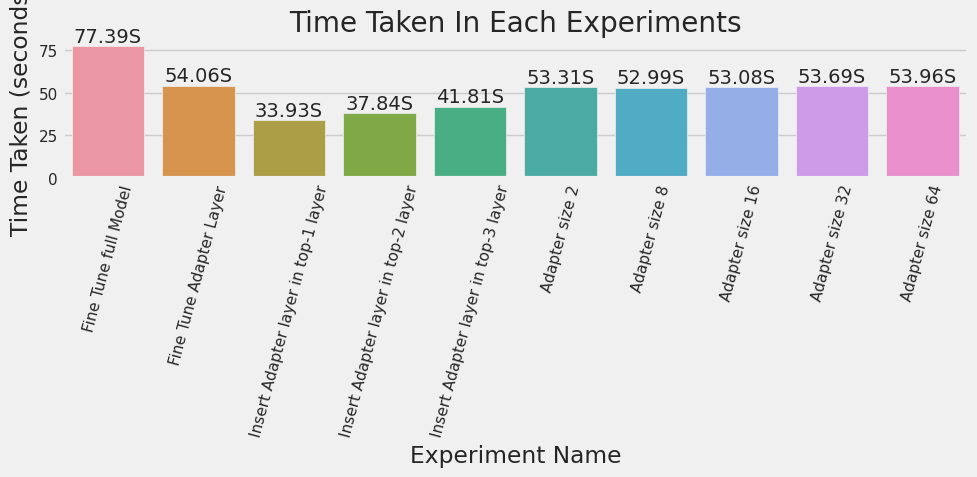

In [18]:
df = all_metric_df[['expriment name','time taken']].copy()
df = df.drop_duplicates()
df["time taken"] = df['time taken'].round(2)
summarize_all_expriment_box_plot(df,x='expriment name',
                                 y='time taken',
                                 xlabel = 'Experiment Name',
                                 ylabel='Time Taken (seconds)',
                                 title='Time Taken In Each Experiments',
                                 postfix_add='S')